# Transfer Learning
![Imgur](https://i.imgur.com/7cRJDlG.png)


* **Fine-Tuning** modifies the parameters of an existing CNN to train a new task. The `output layer` is extended with randomly intialized weights for the new task, and a small learning rate is used to tune all parameters from their original values to minimize the loss on the new task. Sometimes, part of the network is frozen (e.g. the convolutional layers) to prevent overfitting. 

* **Feature Extraction** uses a pre-trained deep CNN to compute features for an image. The extracted features are the activations of one layer (usually the last hidden layer) or multiple layers given the image. Classifiers trained on these features can achieve competitive results, sometimes outperforming human-engineered features.

**References**
* Li, Zhizhong, and Derek Hoiem. "Learning without forgetting." In European Conference on Computer Vision, pp. 614-629. Springer International Publishing, 2016.

## Import

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision import models

import matplotlib.pyplot as plt

## Data Preparation

### Dataset - CIFAR 10

* [The CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)
* [StackOverflow](https://stackoverflow.com/questions/66678052/how-to-calculate-the-mean-and-the-std-of-cifar10-data) : How to calculate the `mean` and the `std` of cifar10 data.

### Transforms

In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.49139968, 0.48215827 ,0.44653124),
        (0.24703233, 0.24348505, 0.26158768))                               
  ])

test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.49139968, 0.48215827, 0.44653124),
        (0.24703233, 0.24348505, 0.26158768))
    ])

### Dataset & DataLoader

In [ ]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=1)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=10000, shuffle=True, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified



CIFAR Information:
Image Shape: torch.Size([64, 3, 224, 224])
Label Shape: torch.Size([64])



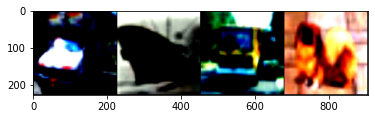

In [ ]:
for idx, (batch_images, batch_labels) in enumerate(train_loader):
    print('\nCIFAR Information:')
    print('Image Shape:', batch_images.shape) # shape (B, C, H, W)
    print('Label Shape:', batch_labels.shape) 
    print('')
    
    # plot images
    sample_batch_images = batch_images[:4, :, :, :] # only show 4 images
    grid = torchvision.utils.make_grid(sample_batch_images)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    break

## Functions of Training & Testing

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# define the tainning routine
def train(model, train_loader, optimizer, loss_function, epoch):
    for idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        output = model(images)
        
        loss = loss_function(output, labels)
        loss.backward()
        
        optimizer.step()
        # print at the interval of 2000 mini-batchs
        if (idx+1)% 2000 == 0:
            print('Epoch no.%d, Mini-batchs:%5d, loss:%.4f' %(epoch+1, idx+1, loss.data))

In [ ]:
# define the test routine to evaluate model performance
def test(model, test_loader):
    correct = 0
    counter = 0
    with torch.no_grad():
        for idx, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            counter += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy from test dataset: %.4f %%' %(100 * correct/counter))
    return (100 * correct/counter)

## 1. Features Extration

### Load Pre-trained Model - VGG16

In [ ]:
vgg16_pretrained = models.vgg16(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
vgg16_pretrained

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Freeze parameters

In [ ]:
# Freeze parameters so we don't backprop through them
for parameter in vgg16_pretrained.parameters():
    parameter.requires_grad = False

### Change the classifier

In [ ]:
vgg16_pretrained.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [ ]:
new_classifier = nn.Sequential(
          nn.Linear(25088, 16384),
          nn.ReLU(),
          nn.Dropout(0.5),
          nn.Linear(16384, 4096),
          nn.ReLU(),
          nn.Linear(4096, 256),
          nn.ReLU(),
          nn.Linear(256, 10)
        )

new_classifier

Sequential(
  (0): Linear(in_features=25088, out_features=16384, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=16384, out_features=4096, bias=True)
  (4): ReLU()
  (5): Linear(in_features=4096, out_features=256, bias=True)
  (6): ReLU()
  (7): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
vgg16_pretrained.classifier = new_classifier
vgg16_pretrained.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=16384, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=16384, out_features=4096, bias=True)
  (4): ReLU()
  (5): Linear(in_features=4096, out_features=256, bias=True)
  (6): ReLU()
  (7): Linear(in_features=256, out_features=10, bias=True)
)

### Loss Function & Optimizer

In [ ]:
optimizer = torch.optim.Adam(vgg16_pretrained.parameters(), lr=0.0001)
loss_function = nn.CrossEntropyLoss()

### Training & Testing Model

In [ ]:
vgg16_pretrained.to(device)
max_accuracy = 0 

for epoch in range(0, 5):
    train(vgg16_pretrained, train_loader, optimizer, loss_function, epoch)
    e_accuracy = test(vgg16_pretrained, test_loader)
    
    if e_accuracy > max_accuracy:
        torch.save(vgg16_pretrained.state_dict(), './best_model.pth')

Accuracy from test dataset: 89.3600 %
Accuracy from test dataset: 92.5120 %
Accuracy from test dataset: 94.9800 %
Accuracy from test dataset: 96.0960 %
Accuracy from test dataset: 97.3060 %


## 2. Fine-Tuning 

### Load Pre-trained Model - VGG16

In [ ]:
vgg16_pretrained = models.vgg16(pretrained=True)

In [ ]:
vgg16_pretrained

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
vgg16_pretrained.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

### Change the last layer

In [ ]:
vgg16_pretrained.classifier[6] = nn.Linear(4096, len(classes))
vgg16_pretrained.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)

### Loss Function & Optimizer 

In [ ]:
optimizer = torch.optim.Adam(vgg16_pretrained.parameters(), lr=0.0001)
loss_function = nn.CrossEntropyLoss()

### Training & Testing Model

In [ ]:
vgg16_pretrained.to(device)
max_accuracy = 0 

for epoch in range(0, 5):
    train(vgg16_pretrained, train_loader, optimizer, loss_function, epoch)
    e_accuracy = test(vgg16_pretrained, test_loader)
    
    if e_accuracy > max_accuracy:
        torch.save(vgg16_pretrained.state_dict(), './best_finetune_model.pth')

Accuracy from test dataset: 89.4680 %
Accuracy from test dataset: 95.0380 %
